# Predicting fungal colony forming units based on real-time air sampling data
## Modeling Capstone Project: Springboard Datascience Career Track
### Notebook by James Clay

### Introduction
#### 1. The Problem:

It is costly and time-consuming to properly conduct viable air sampling and await culturing results from an analytical lab. Air particulate counts, temperature, and relative humidity are common analytes measured during air sampling. It would be cost-efficient to be able to determine whether or not the environment is conducive to mold growth based on real-time sampling data that does not require lengthy analysis time. The objective is to determine whether viable sampling is necessary to confirm colony forming units over a threshold of 10 CFUs.

#### 2. The Data:

This data has been obtained from scanning decades of air sampling records from a hospital. The following are the data fields in the dataset, which we are going to read in the Pandas data frame.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, mean_squared_error, confusion_matrix, classification_report,roc_curve,roc_auc_score
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PowerTransformer
from scipy.stats import randint
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV


import os
import math 

#ignore warning messages to ensure clean outputs
import warnings
warnings.filterwarnings('ignore')

In [2]:
file = 'data\preprocessing.csv'

df = pd.read_csv(file,index_col=0,parse_dates=True)

#df['Date'] = pd.to_datetime(df['Date'])
df['Date'] = pd.to_datetime(df['Date'])
df['Date']=df['Date'].map(dt.datetime.toordinal)

df['cfu'] = pd.to_numeric(df['cfu'])
#df.reset_index()
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 856 entries, 2018-10-15/ed-lot to 2015-04-24/mbh-shuttle-stop
Data columns (total 100 columns):
 #   Column                                                             Non-Null Count  Dtype  
---  ------                                                             --------------  -----  
 0   Date                                                               856 non-null    int64  
 1   Temp                                                               856 non-null    float64
 2   RH                                                                 856 non-null    float64
 3   Total_Particles>0.3                                                856 non-null    float64
 4   Total_Particles>0.5/m3                                             856 non-null    float64
 5   cfu                                                                856 non-null    float64
 6   threshold                                                          856 non-null    int

In [3]:
# linear regression
X = df.drop(columns=(['cfu','threshold']))
y = df.cfu.values
scaler_pt = PowerTransformer()
scaler = StandardScaler()

X['tp3_lg'] = scaler_pt.fit_transform(X[['Total_Particles>0.3']])
X['tp5m3_lg'] = scaler_pt.fit_transform(X[['Total_Particles>0.5/m3']])
X['temp_ss'] = scaler.fit_transform(X[['Temp']])
X['rh_ss'] = scaler.fit_transform(X[['RH']])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

reg = LinearRegression()
reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)

print("R^2: {}".format(reg.score(X_test, y_test)))
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("Root Mean Squared Error: {}".format(rmse))

R^2: 0.6595219009004045
Root Mean Squared Error: 6.20388013788523


##### not great.

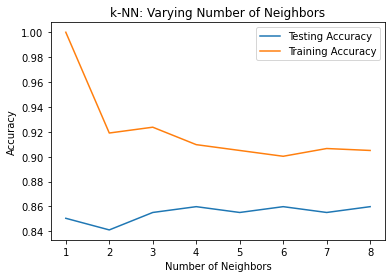

In [4]:
# K-Nearest Neighbors
y = df.threshold.values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

neighbors = np.arange(1, 9)
train_accuracy = np.empty(len(neighbors))
test_accuracy = np.empty(len(neighbors))

# Loop over different values of k
for i, k in enumerate(neighbors):

    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    train_accuracy[i] = knn.score(X_train, y_train)
    test_accuracy[i] = knn.score(X_test, y_test)


plt.title('k-NN: Varying Number of Neighbors')
plt.plot(neighbors, test_accuracy, label = 'Testing Accuracy')
plt.plot(neighbors, train_accuracy, label = 'Training Accuracy')
plt.legend()
plt.xlabel('Number of Neighbors')
plt.ylabel('Accuracy')
plt.show()

looks like 6 or 7 neighbors would be good for highest test accuracy.

In [5]:
knn = KNeighborsClassifier(n_neighbors=6)
knn.fit(X_train,y_train)
y_pred = knn.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print("KNN Score: ",knn.score(X_test, y_test))

[[161  10]
 [ 20  23]]
              precision    recall  f1-score   support

           0       0.89      0.94      0.91       171
           1       0.70      0.53      0.61        43

    accuracy                           0.86       214
   macro avg       0.79      0.74      0.76       214
weighted avg       0.85      0.86      0.85       214

KNN Score:  0.8598130841121495


#### better than linear regression

In [6]:
# logisitic regression
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state=42)

logreg = LogisticRegression()
logreg.fit(X_train, y_train)

y_pred = logreg.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print("Logistic Reg. Score: ",logreg.score(X_test, y_test))

[[164   7]
 [ 20  23]]
              precision    recall  f1-score   support

           0       0.89      0.96      0.92       171
           1       0.77      0.53      0.63        43

    accuracy                           0.87       214
   macro avg       0.83      0.75      0.78       214
weighted avg       0.87      0.87      0.86       214

Logistic Reg. Score:  0.8738317757009346


a lot of false negatives, which is what we want to minimize. erring on the side of caution to ensure CFUs are under threshold.

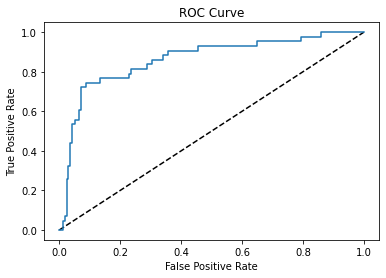

In [7]:
y_pred_prob = logreg.predict_proba(X_test)[:,1]

# ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

In [8]:
# Area under the ROC curve (AUC)
y_pred_prob = logreg.predict_proba(X_test)[:,1]
print("AUC: {}".format(roc_auc_score(y_test, y_pred_prob)))
cv_auc = cross_val_score(logreg, X, y, cv=5, scoring='roc_auc')
print("AUC scores computed using 5-fold cross-validation: {}".format(cv_auc))

AUC: 0.8623691010471917
AUC scores computed using 5-fold cross-validation: [0.63864087 0.91033966 0.89454733 0.87731481 0.92438272]


In [15]:
param_dist = {"max_depth": [3,4,5,6,7,8],
              "max_features": randint(1, 30),
              "min_samples_leaf": randint(1, 9),
              "criterion": ["gini", "entropy"]}

tree = DecisionTreeClassifier()
tree_cv = RandomizedSearchCV(tree, param_dist, cv=5)
tree_cv.fit(X,y)

print("Tuned Decision Tree Parameters: {}".format(tree_cv.best_params_))
print("Best Tree score is {}".format(tree_cv.best_score_))


Tuned Decision Tree Parameters: {'criterion': 'gini', 'max_depth': 5, 'max_features': 21, 'min_samples_leaf': 1}
Best score is 0.8960356317149463
